In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
train_path = "../datasets/adept/train-dev-test-split/train.json"
val_path = "../datasets/adept/train-dev-test-split/val.json"
test_path = "../datasets/adept/train-dev-test-split/test.json"

In [3]:
def combine_data(train_path, val_path, test_path):
    """
    Combining the train/val/test datasets into a single dataset for data analysis.
    """

    with open(train_path, "r") as train_file:
        train_data = json.load(train_file)

    with open(val_path, "r") as val_file:
        val_data = json.load(val_file)

    with open(test_path, "r") as test_file:
        test_data = json.load(test_file)
    
    train_df = pd.DataFrame(train_data)
    val_df = pd.DataFrame(val_data)
    test_df = pd.DataFrame(test_data)
    train_df["dataset"] = "train"
    val_df["dataset"] = "val"
    test_df["dataset"] = "test"
    combined_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

    return combined_df

In [71]:
combined_df = combine_data(train_path, val_path, test_path)
combined_df.head()

,sentence1,sentence2,modifier,noun,label,idx,dataset
0,The effect of sleeping is rejuvenation.,The effect of additional sleeping is rejuvenat...,additional,sleeping,3,13484,train
1,A toothbrush is for fresh breath.,A regular toothbrush is for fresh breath.,regular,toothbrush,2,2620,train
2,A scene is painted.,A negative scene is painted.,negative,scene,2,3324,train
3,A bone breaks a tooth.,An alleged bone breaks a tooth.,alleged,bone,2,10610,train
4,A trip causes a happening.,A fabulous trip causes a happening.,fabulous,trip,2,14917,train


In [25]:
# Numbers of instances
instance_counts = len(combined_df)
instance_counts

16115

In [26]:
# define label mappings for different numbers of labels
 
five_class_label = {
    0: "(0) Impossible",
    1: "(1) Less likely",
    2: "(2) Equally likely",
    3: "(3) More likely",
    4: "(4) Necessarily true"
}

three_class_label = {
    0: "(-1) Decrease in plausibility",
    1: "(-1) Decrease in plausibility",
    2: "(0) Equally likely",
    3: "(1) Increase in plausibility",
    4: "(1) Increase in plausibility"
}

In [34]:
def label_dstribution(df, label_mapping, title):
    df["label_strings"] = df["label"].map(label_mapping)
    label_counts = df["label_strings"].value_counts()
    label_proportions = label_counts / instance_counts
    label_stat = pd.DataFrame({"Label counts": label_counts,
                                "Label proportions": label_proportions})
    print(f"\n{label_stat}")

    # plot_label_distribution
    fig, ax = plt.subplots(figsize=(6, 6), layout='constrained')
    bars = ax.bar(label_proportions.index, label_proportions, color="blue")

    for bar, proportion in zip(bars, label_proportions):
        plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.01, f"{proportion:.2f}", fontsize=10)
    plt.xlabel("Label")
    plt.ylabel("Proportion")
    plt.title(title)
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.show()
    return None


                      Label counts  Label proportions
label_strings                                        
(2) Equally likely           10805           0.670493
(0) Impossible                2221           0.137822
(1) Less likely               1868           0.115917
(3) More likely               1132           0.070245
(4) Necessarily true            89           0.005523


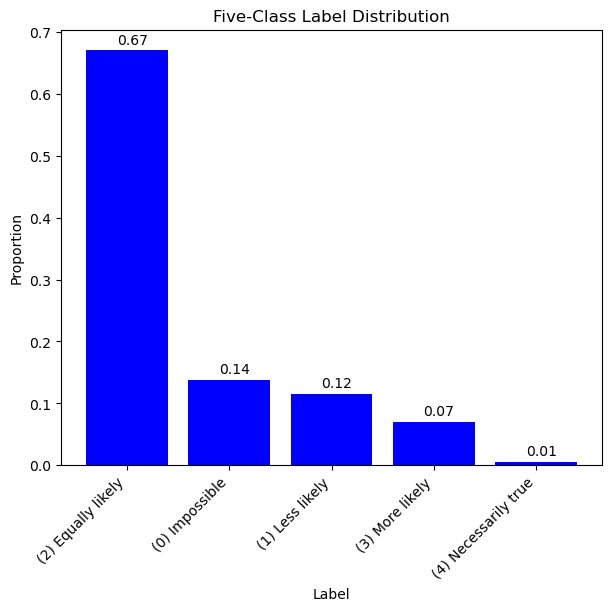


                               Label counts  Label proportions
label_strings                                                 
(0) Equally likely                    10805           0.670493
(-1) Decrease in plausibility          4089           0.253739
(1) Increase in plausibility           1221           0.075768


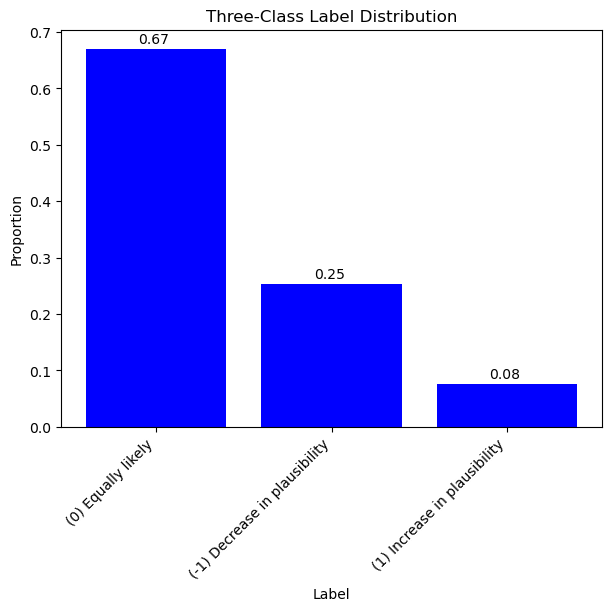

In [35]:
label_dstribution(combined_df, five_class_label, "Five-Class Label Distribution")
label_dstribution(combined_df, three_class_label, "Three-Class Label Distribution")

## Label Distribution
- 5-Class: The labels are highly imbalanced, with "Equally likely" representing up to 0.67 and only 0.01 for "Necessarily true."
- 3-Class: 
    - Labels are groupped similar to the original paper, that "(0) Impossible" and "(1) Less likely" are mapped to "Decrease in plausibility," while "(3) More likely" and "(4) Necessarily true" are mapped to "Increase in plausibility." 
    - "Equally likely" still has the largest proportion, followed by "Decrease in plausibility" and "Increase in plausibility."

In [40]:
def compute_modifiers(df):
    
    # 1. Counting numbers of unique modifiers and the print the top 10 frequent modifiers.
    print(f"\n----- MODIFIERS -----")
    num_unique_modifiers = len(df["modifier"].unique())
    print(f"Counts of unique modifiers: {num_unique_modifiers}")
    unique_modifier_counts = df["modifier"].value_counts()
    sorted_modifiers = unique_modifier_counts.sort_values(ascending=False)
    print(f"\nTop 10 frequent modifiers and their counts: \n{sorted_modifiers[:10]}")
    
    # 2. Plot frequency and ranking for unique modifiers.
    counts_df = pd.DataFrame({
        "modifier": sorted_modifiers.index,
        "count": sorted_modifiers.values
    })
    counts_df["ranking"] = counts_df["count"].rank(ascending=False, method="dense")
    plt.figure()
    colors = counts_df["count"]
    plt.scatter(counts_df["ranking"], counts_df["count"], c=colors, alpha= 0.3)
    plt.xlabel('Ranking (descending order of counts)')
    plt.ylabel('Counts')
    plt.title('Unique Modifiers Rank-Frequency Distribution')
    plt.show()
    
    return None


----- MODIFIERS -----
Counts of unique modifiers: 3151

Top 10 frequent modifiers and their counts: 
modifier
virtual       486
former        438
dead          367
fake          248
artificial    238
historic      221
false         215
future        189
potential     189
new           186
Name: count, dtype: int64


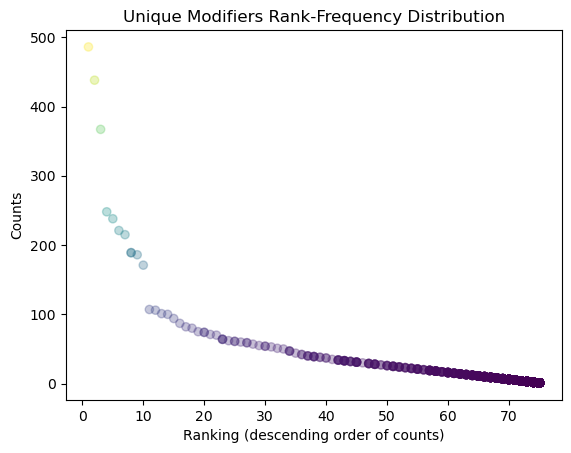

In [41]:
compute_modifiers(combined_df)

## Unique Modifiers Rank-Frequency Distribution
- The top 10 frequent modifiers (from the yellow to blue dots) have much higher frequencies than the rest (the purple dots).
- Long tail: The stronger color in the tail demonstrates that many modifiers occur only once.

## Investigate Modifier-Noun Pairs

In [89]:
def count_freq_and_top10_pairs(df):
    """
    Count the frequency and determine the top 10 ranking of Modifier-Noun pairs based on their counts.
    """
    pair_counts = df.groupby(["modifier","noun"]).size().reset_index(name="pair_counts")
    sorted_pair_counts = pair_counts.sort_values(by="pair_counts", ascending=False)
    top10_pairs = sorted_pair_counts.head(10)
    pair_counts_with_label = pd.merge(df[['modifier', 'noun', 'label']], pair_counts, on=['modifier', 'noun'])
    label_counts = pair_counts_with_label.groupby(["modifier", "noun", "label"]).size().reset_index(name="label_counts")
    label_counts_pivot = label_counts.pivot_table(index=["modifier", "noun"], columns="label", values="label_counts", fill_value=0).reset_index()
    label_counts_pivot_filtered = label_counts_pivot[label_counts_pivot[['modifier', 'noun']].apply(tuple, axis=1).isin(top10_pairs[['modifier', 'noun']].apply(tuple, axis=1))]
    label_counts_pivot_filtered = label_counts_pivot_filtered.set_index(['modifier', 'noun']).reindex(index=top10_pairs.set_index(['modifier', 'noun']).index).reset_index()
    return top10_pairs, label_counts_pivot_filtered

In [90]:
# display overall top 10 pairs
overall_top10_pairs, label_counts_pivot = count_freq_and_top10_pairs(combined_df)
print(f'\nTop 10 frequent pairs and their counts:')
overall_top10_pairs


Top 10 frequent pairs and their counts:


,modifier,noun,pair_counts
3789,false,milk,10
8064,old,graveyard,8
5159,great,banjo,7
2623,deputy,secretary,7
3761,false,food,7
3676,fake,menu,7
3654,fake,gun,7
12604,virtual,calendar,7
1415,certified,grocer,7
6556,likely,comb,6


In [91]:
label_counts_pivot

label,modifier,noun,0,1,2,3,4
0,false,milk,6.0,3.0,1.0,0.0,0.0
1,old,graveyard,0.0,0.0,6.0,2.0,0.0
2,great,banjo,0.0,0.0,6.0,0.0,1.0
3,deputy,secretary,0.0,0.0,6.0,1.0,0.0
4,false,food,1.0,6.0,0.0,0.0,0.0
5,fake,menu,1.0,6.0,0.0,0.0,0.0
6,fake,gun,1.0,4.0,2.0,0.0,0.0
7,virtual,calendar,0.0,0.0,7.0,0.0,0.0
8,certified,grocer,0.0,0.0,6.0,1.0,0.0
9,likely,comb,2.0,0.0,4.0,0.0,0.0


In [68]:
# display top 10 pairs for class "Impossible"
df_label_0 = combined_df[combined_df["label"] == 0]
label_0_top10_pairs = count_freq_and_top10_pairs(df_label_0)
print(f'\nTop 10 frequent pairs and their counts in class "Impossible":')
label_0_top10_pairs


Top 10 frequent pairs and their counts in class "Impossible":


,modifier,noun,pair_counts
636,false,milk,6
376,dead,radio,6
806,former,train,5
1723,virtual,bench,5
294,dead,cat,5
305,dead,council,5
1720,virtual,basket,5
358,dead,mouse,5
1541,simulated,razor,5
313,dead,dog,5


In [70]:
# display top 10 pairs for class "Necessarily true"
df_label_4 = combined_df[combined_df["label"] == 4]
label_4_top10_pairs = count_freq_and_top10_pairs(df_label_4)
print(f'\nTop 10 frequent pairs and their counts in class "Necessarily true":')
label_4_top10_pairs


Top 10 frequent pairs and their counts in class "Necessarily true":


,modifier,noun,pair_counts
18,dead,duck,3
0,aerobic,fermentation,1
65,real,bread,1
63,possible,everything,1
62,perfect,umbrella,1
61,past,game,1
60,past,century,1
59,new,explosive,1
58,natural,meat,1
57,military,general,1


Imbalance is also reflected in the counts of top 10 pairs in “Impossible” vs “Necessarily true”

- For impossible: some pairs are valid (so the invalid comes from the context), and some are already an invalid pair
</aside>